In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_twoIslandStudy.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2025-06-17_twoBunch_forMuons_6GeV.yml")

In [3]:
csrTF = False
evalElement = "PENT"



inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_7439560684556372554.h5, and reinit to tao


In [4]:
launchTwissCorrection(tao)

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [0.13755483 0.95354498 0.40561992 2.20428422]
Objective Function Value at Optimal Parameters: 1.5713418827278803e-09
Number of Iterations: 93
Converged: True


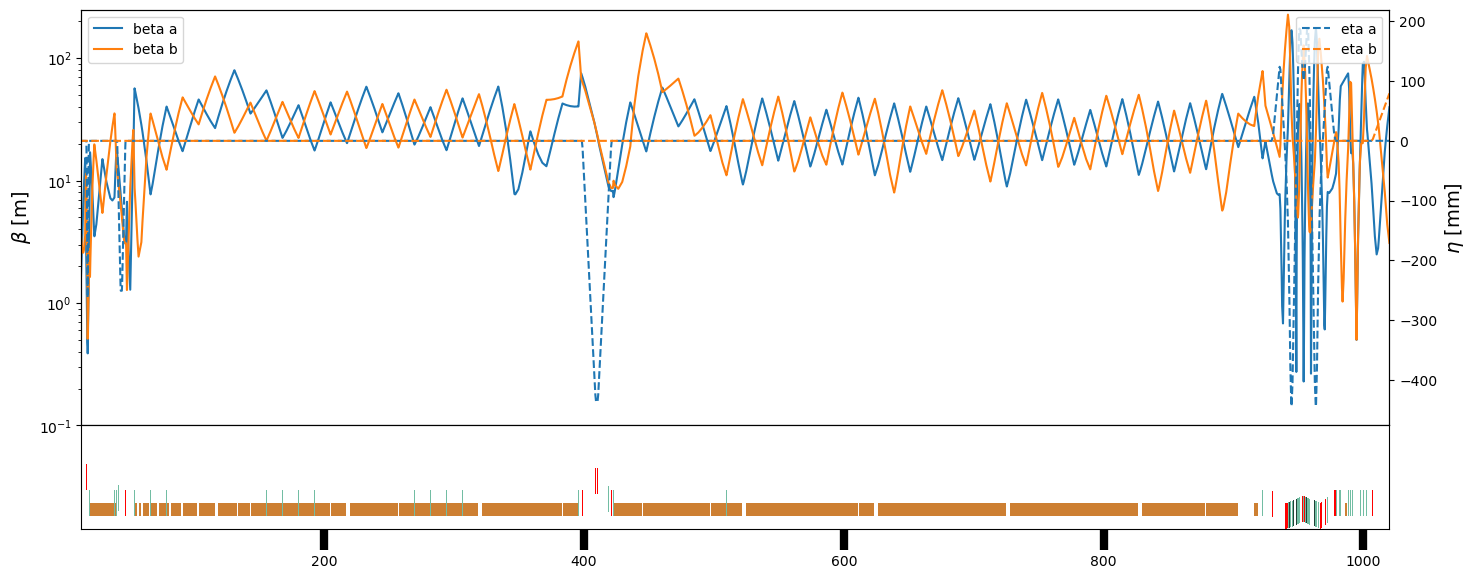

In [5]:
floorplanPlot(tao)

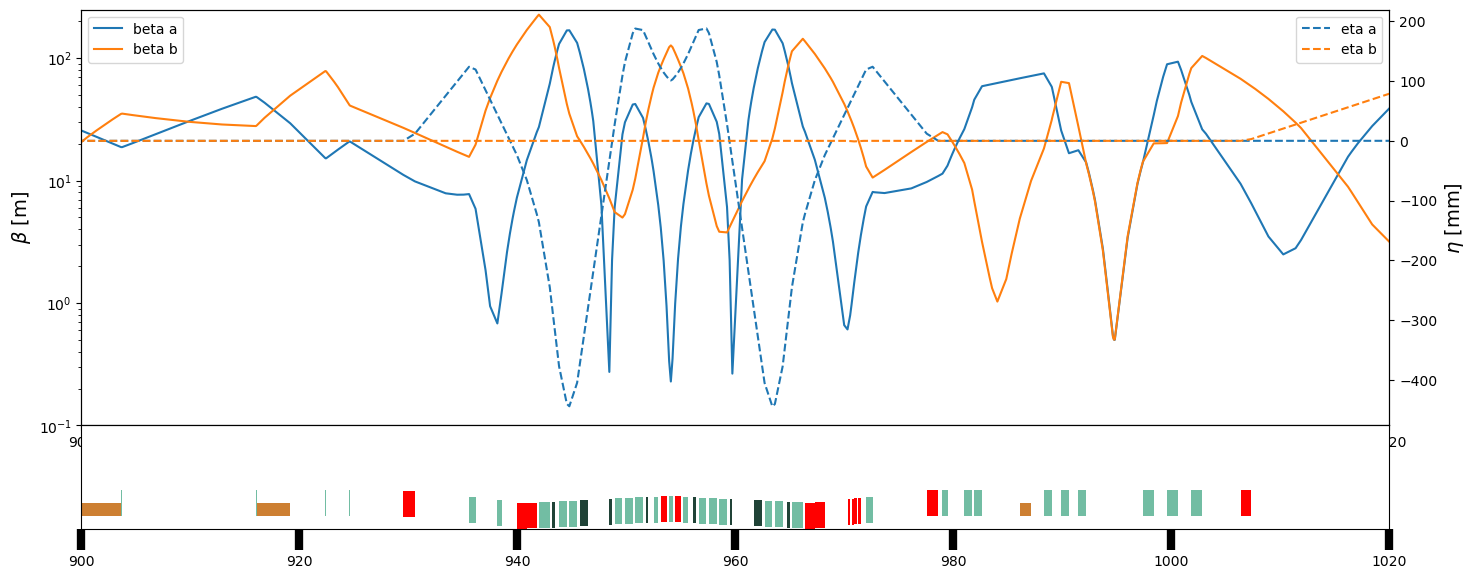

In [6]:
floorplanPlot(tao, zmin = 900)

In [7]:
goldenTransportMatrix = getMatrix(tao, "BEGBC20", "MFFF", print = True)

-1.207484,-4.962570,-0.000000,-0.000000,0.000000,0.000012
-0.084683,-1.176201,0.000000,0.000000,0.000000,-0.000001
-0.000000,-0.000000,-0.636143,6.526881,0.000000,-0.000000
-0.000000,-0.000000,-0.094573,-0.601645,0.000000,-0.000000
-0.000003,-0.000021,0.000000,0.000000,1.000000,-0.007001
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
setLattice(tao, **importedDefaultSettings)

In [9]:
launchTwissCorrection(tao)

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [4.19319006 1.98771984 2.95172175 1.40376845]
Objective Function Value at Optimal Parameters: 8.773895145881801e-10
Number of Iterations: 211
Converged: True


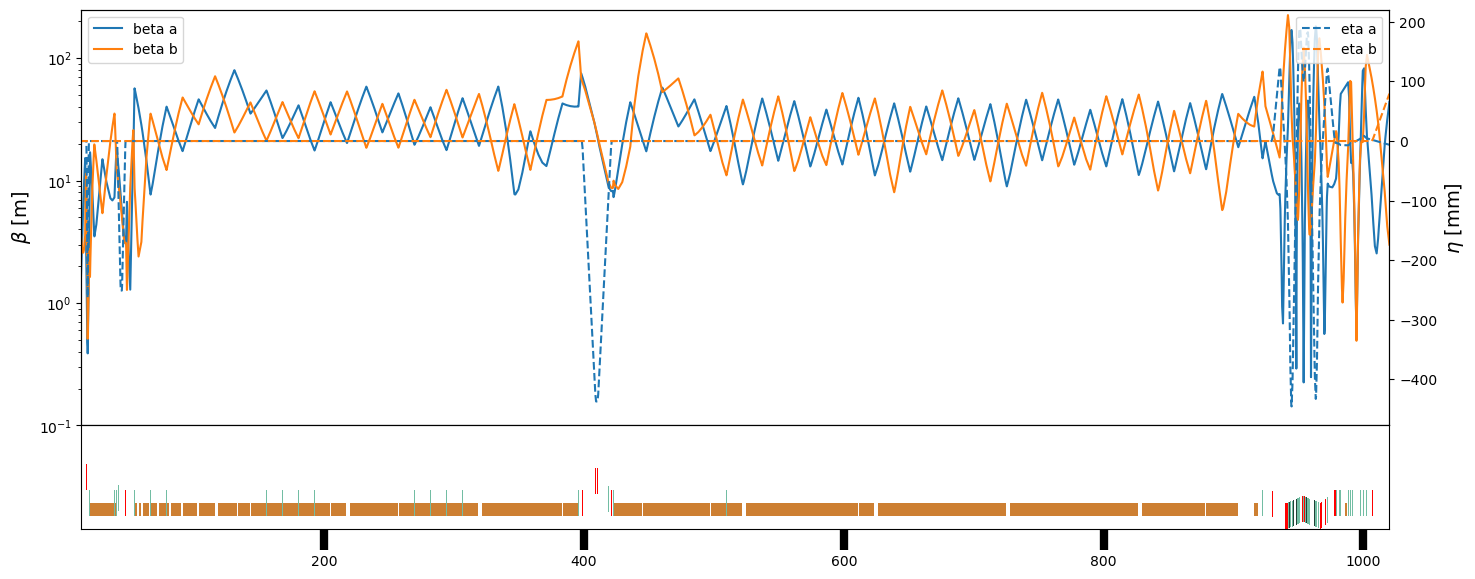

In [10]:
floorplanPlot(tao)

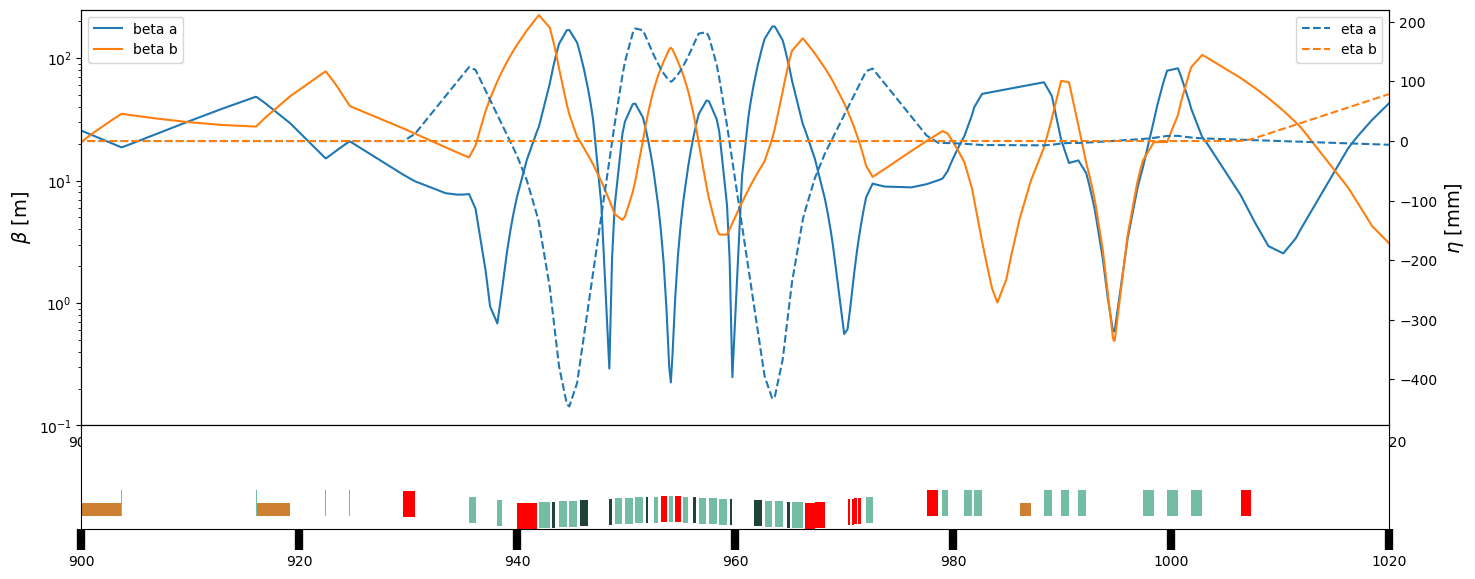

In [11]:
floorplanPlot(tao, zmin = 900)

In [12]:
naiveTransportMatrix = getMatrix(tao, "BEGBC20", "MFFF", print = True)

-1.153986,-4.900069,-0.000000,-0.000000,0.000000,-0.003165
-0.062343,-1.131285,0.000000,0.000000,0.000000,-0.000094
-0.000000,-0.000000,-0.732191,4.990598,0.000000,-0.000000
0.000000,-0.000000,-0.098276,-0.695916,0.000000,-0.000000
0.000089,0.003120,0.000000,0.000000,1.000000,-0.006796
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [13]:
np.linalg.norm( goldenTransportMatrix - naiveTransportMatrix )

1.5451852807627904

In [14]:
originalSettings = [ importedDefaultSettings[ele] for ele in ["Q1EkG", "Q2EkG", "Q3EkG", "Q4EkG", "Q5EkG", "Q6EkG"] ]
originalSettings

[96.7866, -92.5374, 66.1302, 79.3608, -14.0238, -85.3626]

In [15]:
# OPTIONAL: disable all apertures. Very nonphysical, but I want to see if this solves some headaches
# totalNumElements = len(tao.lat_list("*", "ele.name"))
# for eleII in range(totalNumElements):
#     try:
#         tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
#     except:
#         pass

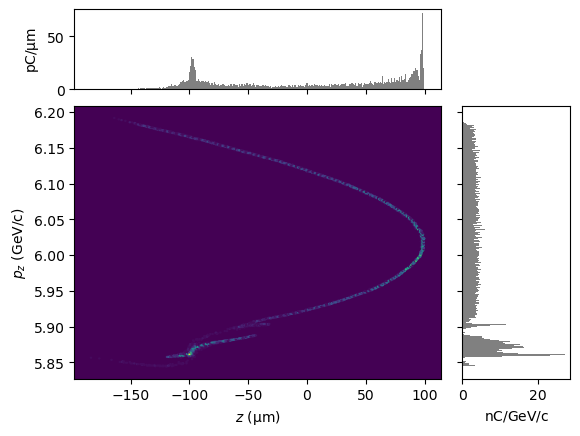

In [16]:
trackBeam( tao, **importedDefaultSettings )
P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

In [17]:
from scipy.optimize import minimize

def objective(params, tao):

    overrides = {
            "Q1EkG" : params[0],
            "Q2EkG" : params[1],
            "Q3EkG" : params[2],
            "Q4EkG" : params[3],
            "Q5EkG" : params[4],
            "Q6EkG" : params[5],
            }

    #print(overrides)
    
    setLattice(
        tao,
        **(importedDefaultSettings | overrides)

    )
    

    error = np.linalg.norm( goldenTransportMatrix - getMatrix(tao, "BEGBC20", "MFFF") )

    #Optional: Prefer small changes to the quads
    changeCost = 1e-9 * np.linalg.norm( np.array( params ) - np.array( originalSettings ) ) ** 2
    error += changeCost

    return error

In [18]:
initialGuess = originalSettings

#For now, just hardcoding bounds... could generalize if required
#From "bounds.yml" as of 2025-06-18
# Q1EkGBounds :  (0, 388)  #BCON = 133
# Q2EkGBounds :  (-364, 0) #BCON = -136
# Q3EkGBounds :  (0, 299)  #BCON = 94
# Q4EkGBounds :  (0, 304)  #BCON = 118
# Q5EkGBounds :  (-117, 0) #BCON = -17
# Q6EkGBounds :  (-301, 0) #BCON = -142

bounds = [(0,388), (-364,0), (0, 299), (0, 304), (-117, 0), (-301, 0)]


# Perform optimization using Nelder-Mead
result = minimize(
    objective, 
    initialGuess, 
    method='Nelder-Mead',
    bounds = bounds,
    args = (tao, )
)



print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")

Optimization Results:
Optimal Parameters: [ 98.43545673 -92.25702075  65.04919399  82.83331943 -13.55400322
 -86.9508716 ]
Objective Function Value at Optimal Parameters: 0.01869485518302016
Number of Iterations: 578
Converged: True


In [19]:
objective( result.x, tao ) 

0.01869485518302016

In [20]:
getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.205024,-4.964441,-0.000000,-0.000000,0.000000,0.012997
-0.083573,-1.174163,0.000000,0.000000,0.000000,0.000492
-0.000000,-0.000000,-0.636414,6.526903,0.000000,-0.000000
-0.000000,-0.000000,-0.094519,-0.601945,0.000000,-0.000000
-0.000493,-0.012817,0.000000,0.000000,1.000000,-0.008259
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
